# Homework 3

David Marcell Prifer (`prifer@kth.se`)

AI declaration: No direct use of LLMs. **AI usage Level 2** is inherent due to the built-in AI assistant of PyCharm that assists with syntax, debugging, code generation, etc. Code inspirations were taken from the coursebook.


## Load and inspect data

In [45]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysindy as ps


folder = r'C:\Users\prife\OneDrive - KTH\KTH\01 Courses\Data-driven Methods\HW3' + "\\"
data = loadmat(folder + "DataHw3Q1.mat")

X = np.array(data['x'])
t = np.array(data['t'])
t = t[:, 0]  # to flatten it

pd.DataFrame(X).describe()

,0,1
count,1001.000000,1001.000000
mean,0.574825,0.679735
std,0.913062,0.580926
min,-1.308773,-0.542237
25%,0.079300,0.280303
50%,0.713524,0.896526
75%,1.297615,1.171106
max,1.917320,1.267421


(1001, 2)
(1001,)


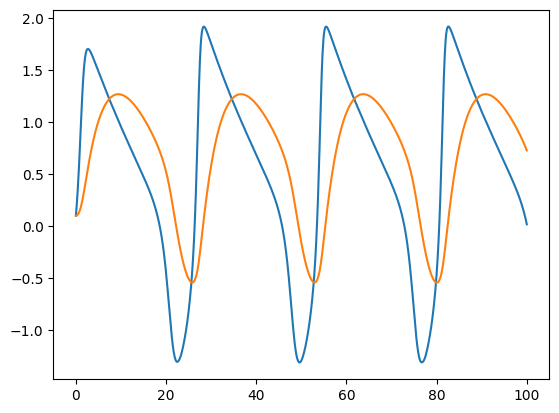

In [46]:
print(X.shape)
print(t.shape)

plt.plot(t,X)
plt.show()

## Problem 1: SINDy

$$
\mathbf{X} =
\begin{bmatrix}
x_1(t_1) & x_2(t_1) \\
x_1(t_2) & x_2(t_2) \\
\vdots & \vdots  \\
x_1(t_{1001}) & x_2(t_{1001})
\end{bmatrix}
\downarrow\!\!\text{time}
$$

The ODEs that describe the system are

$$
\dot{x}_1 = \sum_{j,k} c_{j,k} \, x_1^j \, x_2^k,
$$

and

$$
\dot{x}_2 = \sum_{j,k} d_{j,k} \, x_1^j \, x_2^k,
$$

with the constraint $ j+k \leq 3 $ which means the maximum polynomial is 3.

In [48]:
# from pySINDY documentation at https://pysindy.readthedocs.io/en/latest/examples/tutorial_1/example.html
differentiation_method = ps.FiniteDifference()
feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer
)

model.fit(X, t=t, feature_names=["x1", "x2"])

model.print()

(x1)' = 0.499 1 + 0.998 x1 + -0.998 x2 + -0.333 x1^3
(x2)' = 0.200 x1 + -0.160 x2


So, the non-zero $c_{j,k}$ and $d_{j,k}$ coefficients are

$$
\begin{align*}
c_{0,0} &= 0.499 \\
c_{1,0} &= 0.998 \\
c_{0,1} &= -0.998 \\
c_{3,0} &= -0.333
\end{align*}
$$

$$
\begin{align*}
d_{1,0} &= 0.2 \\
d_{0,1} &= -0.16
\end{align*}
$$


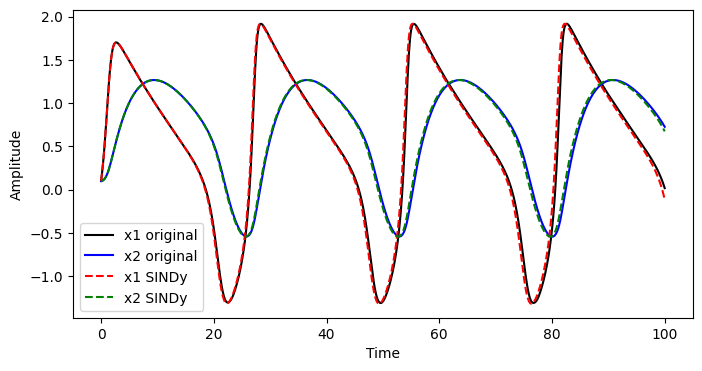

In [54]:
x0 = X[0]

X_sim = model.simulate(x0, t) # Simulate the system

plt.figure(figsize=(8,4))
plt.plot(t, X[:,0], 'k', label='x1 original')
plt.plot(t, X[:,1], 'b', label='x2 original')
plt.plot(t, X_sim[:,0], 'r--', label='x1 SINDy')
plt.plot(t, X_sim[:,1], 'g--', label='x2 SINDy')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Problem 2: Neural Network

The SVM classification problem from P3 is chosen:<br>
Based on a labelled data set from stress-strain measurements, train a model that finds which material could the unlabelled data belong to.<br>

First I recreate the SVM algorithm to be able to compare different metrics

SVM Accuracy on validation set: 96.50%


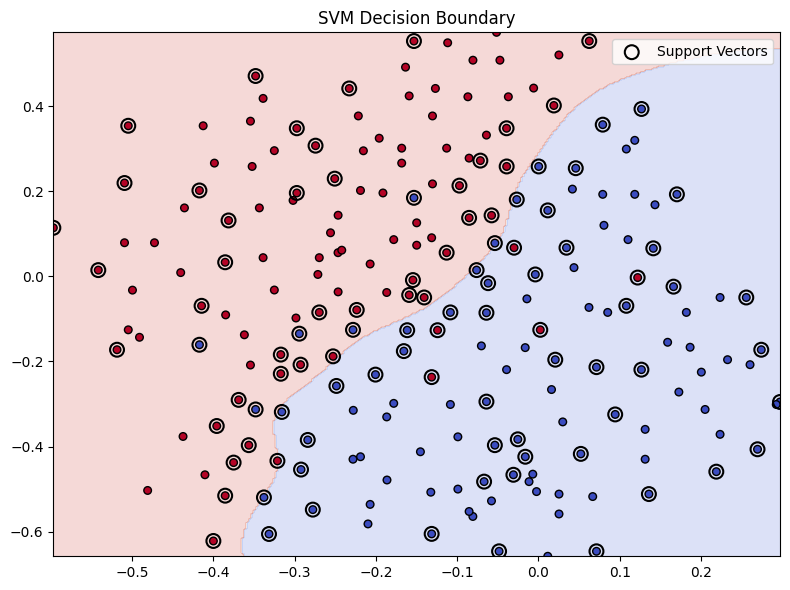

In [61]:
from sklearn import svm, metrics

data = loadmat(folder + "DataSet3.mat")

X = data['X']
y = data['y'].ravel()
Xval = data['Xval']
yval = data['yval'].ravel()

# Normalize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# Xval = scaler.transform(Xval)

# SVM with Gaussian (RBF) kernel

C = 1.0
sigma = 0.1
gamma = 1 / (2 * sigma ** 2)  # here the rbf is parametrized by gamma

model = svm.SVC(C=C, kernel='rbf', gamma=gamma)
model.fit(X, y.ravel())

svm_pred = model.predict(Xval)
svm_acc = metrics.accuracy_score(yval, svm_pred)

print(f"SVM Accuracy on validation set: {svm_acc * 100:.2f}%")

def plot_decision_boundary(model, X, y):
    # Define grid based on exact min and max
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    # Create grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Predict on grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

    # Clip axes to exact data range
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.title("SVM Decision Boundary")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X, y)

![title](SVM_matlab.png)


Above code successfully reproduced the MATLAB results (see above, so now I can start comparing it with a simple ANN.